In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Create a connection
conn = psycopg2.connect(
    host = "localhost",
    port = 5432, 
    database = "dvdrental",
    user = "postgres",
    password= "nguyenquanghuy25",
)

## VD1: 
- Tìm các bộ phim đã thuê chưa trả

In [3]:
q = """
select 
    b.customer_id,
    (b.first_name || ' ' || b.last_name) as full_name,
    phone,
    c.address,
    e.title,
    rental_date
from rental as a 
                left join customer as b
                    on a.customer_id = b.customer_id  
                left join address as c
                    on b.address_id = c.address_id
                left join inventory as d
                    on a.inventory_id = d.inventory_id
                left join film as e
                    on d.film_id = e.film_id
where return_date is null
"""
pd.read_sql(q,conn)

,customer_id,full_name,phone,address,title,rental_date
0,554,Dwayne Olvera,62127829280,1447 Imus Place,Academy Dinosaur,2005-08-21 00:30:32
1,366,Brandon Huey,99883471275,1912 Emeishan Drive,Ace Goldfinger,2006-02-14 15:16:03
2,111,Carmen Owens,272234298332,1378 Alvorada Avenue,Affair Prejudice,2006-02-14 15:16:03
3,590,Seth Hannon,864392582257,1759 Niznekamsk Avenue,African Egg,2006-02-14 15:16:03
4,108,Tracy Cole,371490777743,1002 Ahmadnagar Manor,Ali Forever,2006-02-14 15:16:03
...,...,...,...,...,...,...
178,274,Naomi Jennings,959949395183,1884 Shikarpur Avenue,Wild Apollo,2006-02-14 15:16:03
179,374,Jeremy Hurtado,600264533987,1133 Rizhao Avenue,Window Side,2006-02-14 15:16:03
180,216,Natalie Meyer,873492228462,1201 Qomsheh Manor,Women Dorado,2006-02-14 15:16:03
181,532,Neil Renner,478380208348,1817 Livorno Way,World Leathernecks,2006-02-14 15:16:03


## VD2: 
- Tìm ra các bộ phim đã trễ hạn 
- Các bộ phim này nằm ở inventory nào 
- Các bộ phim này do ai thuê
- Các bộ phim này thuộc category nào

In [4]:
q = """
select 
    b.film_id,
    c.title,
    a.rental_date, 
    a.return_date, 
    rental_duration,
    DATE_PART('day', a.return_date - a.rental_date) as gap_1,
    DATE_PART('day',now() - a.return_date) as gap_2
from rental a 
    left join inventory b 
        on a.inventory_id = b.inventory_id
    left join film c 
        on b.film_id= c.film_id
where 
    (DATE_PART('day', a.return_date - a.rental_date) > rental_duration) 
        or (
            (rental_date is null) 
            AND
            (DATE_PART('day',now() - a.return_date) > rental_duration)
            ) 
"""
pd.read_sql(q,conn)

,film_id,title,rental_date,return_date,rental_duration,gap_1,gap_2
0,535,Love Suicides,2005-05-24 23:04:41,2005-06-03 01:43:41,6,9.0,6291.0
1,450,Idols Snatchers,2005-05-24 23:05:21,2005-06-02 04:33:21,5,8.0,6292.0
2,396,Hanging Deep,2005-05-25 00:02:21,2005-05-31 22:44:21,5,6.0,6293.0
3,971,Whale Bikini,2005-05-25 00:09:02,2005-06-02 20:56:02,4,8.0,6291.0
4,499,King Evolution,2005-05-25 00:22:55,2005-05-30 04:28:55,3,5.0,6295.0
...,...,...,...,...,...,...,...
6398,119,Caper Motions,2005-08-23 22:18:51,2005-08-31 19:55:51,6,7.0,6201.0
6399,771,Scorpion Apollo,2005-08-23 22:19:33,2005-09-02 02:19:33,3,9.0,6200.0
6400,846,Sting Personal,2005-08-23 22:21:03,2005-08-31 03:09:03,3,7.0,6202.0
6401,439,Hunchback Impossible,2005-08-23 22:43:07,2005-08-31 21:33:07,4,7.0,6201.0


In [5]:
q = """
select 
    distinct b.inventory_id
from rental a 
    left join inventory b 
        on a.inventory_id = b.inventory_id
    left join film c 
        on b.film_id= c.film_id
where 
    (DATE_PART('day', a.return_date - a.rental_date) > rental_duration) 
        or (
            (rental_date is null) 
            AND
            (DATE_PART('day',now() - a.return_date) > rental_duration)
            ) 
"""
pd.read_sql(q,conn)

,inventory_id
0,1489
1,273
2,2574
3,951
4,4326
...,...
3505,3221
3506,4035
3507,3858
3508,3984


In [6]:
q = """
select distinct
    d.customer_id, first_name, last_name,
    count(*) as n_film
from rental a 
    left join inventory b 
        on a.inventory_id = b.inventory_id
    left join film c 
        on b.film_id= c.film_id
    left join customer d
        on a.customer_id = d.customer_id
where 
    (DATE_PART('day', a.return_date - a.rental_date) > rental_duration) 
    OR (
            (rental_date is null) 
            AND
            (DATE_PART('day',now() - a.return_date) > rental_duration)
        ) 
Group by d.customer_id, first_name, last_name
order by n_film desc
"""
pd.read_sql(q,conn)

,customer_id,first_name,last_name,n_film
0,526,Karl,Seal,25
1,469,Wesley,Bull,24
2,181,Ana,Bradley,22
3,137,Rhonda,Kennedy,21
4,295,Daisy,Bates,21
...,...,...,...,...
594,401,Tony,Carranza,3
595,413,Marvin,Yee,3
596,97,Annie,Russell,2
597,188,Melanie,Armstrong,2


In [7]:
run_date = '2006-02-15'

In [8]:
q= """
select 
    rental_date,
    to_timestamp('{}', 'yyyy-MM-dd') as today
from rental
limit 3
""".format(run_date)
pd.read_sql(q,conn)

,rental_date,today
0,2005-05-24 22:54:33,2006-02-14 17:00:00+00:00
1,2005-05-24 23:03:39,2006-02-14 17:00:00+00:00
2,2005-05-24 23:04:41,2006-02-14 17:00:00+00:00


## Ex 3:
- Các bộ phim được thuê trong khoảng thời gian nào
- Tìm ra top 5 film có doanh thu nhiều nhất vào tháng 1 (có plot)
- Tương tự làm cho tất cả các tháng trong năm

In [9]:
q ="""
select 
    MIN(rental_date) as min_date,
    MAX(rental_date) as max_date
from rental
"""
pd.read_sql(q,conn)

,min_date,max_date
0,2005-05-24 22:53:30,2006-02-14 15:16:03


In [10]:
q = """
select 
    f.film_id,
    f.title,
    Count(*) as num_rentals,
    SUM(amount) as total_amount
from payment as p left join rental as r
                            on p.rental_id = r.rental_id
                  left join inventory as i 
                            on r.inventory_id = i.inventory_id
                  left join film as f
                            on i.film_id = f.film_id
where DATE_PART('month',rental_date ) = 2 AND DATE_PART('year', rental_date) = 2006
group by f.film_id, f.title
order by SUM(amount) desc
limit 5
"""
df = pd.read_sql(q,conn)
df

,film_id,title,num_rentals,total_amount
0,542,Lust Lock,2,16.95
1,820,Sons Interview,2,10.97
2,86,Boogie Amelie,1,9.98
3,243,Doors President,2,9.98
4,861,Suit Walls,2,9.98


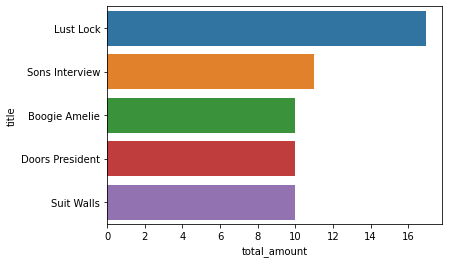

In [11]:
fig, ax = plt.subplots()
sns.barplot(
    y = 'title',
    x =  'total_amount',
    orient = 'h',
    ax = ax,
    data = df
)
plt.show()

In [12]:
window = """
partition by date_part('month', rental_date)
order by SUM(amount) desc
"""

q = """
select *
from (
    select 
        DATE_PART('month', rental_date) as month, 
        f.film_id,
        f.title,
        sum(CASE WHEN amount IS NULL THEN 0 ELSE amount END) as total_amount,
        rank() over({}) as ranking
    
    from payment as p left join rental as r
                                on p.rental_id = r.rental_id
                      left join inventory as i 
                                on r.inventory_id = i.inventory_id
                      left join film as f
                                on i.film_id = f.film_id
    where 
        rental_date >= '2005-01-01' AND 
        rental_date < '2006-01-01'
    group by month, f.film_id, title
    order by month, total_amount desc
) as temp
where ranking <= 5
""".format(window)
pd.read_sql(q,conn)

,month,film_id,title,total_amount,ranking
0,6.0,879,Telegraph Voyage,47.95,1
1,6.0,284,Enemy Odds,36.95,2
2,6.0,307,Fellowship Autumn,33.94,3
3,6.0,239,Dogma Family,33.94,3
4,6.0,330,Forrester Comancheros,33.94,3
5,7.0,764,Saturday Lambs,103.87,1
6,7.0,460,Innocent Usual,98.87,2
7,7.0,893,Titans Jerk,97.86,3
8,7.0,444,Hustler Party,95.90,4
9,7.0,1000,Zorro Ark,91.88,5


## EX5:
- Có bao nhiêu nhân viên
- Tạo bảng doanh số từng tháng cho nhân viên theo dạng sau


In [13]:
# Có bao nhiêu nhân viên 
q = """
select distinct COUNT(staff_id) as num_staff
from staff
"""

pd.read_sql(q,conn)

,num_staff
0,2


In [14]:
# Tạo bảng doanh số từng tháng cho nhân viên theo dạng sau
q = """
select 
    substring(cast(payment_date as text), 1, 7) as ym,
    s.staff_id,
    SUM(amount) as monthly_amount
from staff as s left join rental as r on s.staff_id = r.staff_id
                left join payment as p on r.rental_id = p.rental_id 
where substring(cast(payment_date as text), 1, 7) is not null
group by ym, s.staff_id
order by ym, s.staff_id

"""
df = pd.read_sql(q,conn)

In [15]:
df

,ym,staff_id,monthly_amount
0,2007-02,1,4139.91
1,2007-02,2,4211.93
2,2007-03,1,11990.27
3,2007-03,2,11896.29
4,2007-04,1,14150.36
5,2007-04,2,14409.10
6,2007-05,1,218.17
7,2007-05,2,296.01


In [16]:
# chuyển từ long data sang wide data -> pivot
df2 = df.pivot(index = "ym", columns= "staff_id", values = "monthly_amount")
df2

staff_id,1,2
ym,,
2007-02,4139.91,4211.93
2007-03,11990.27,11896.29
2007-04,14150.36,14409.10
2007-05,218.17,296.01


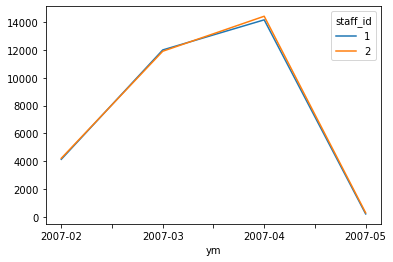

In [17]:
# Vẽ 
fig, ax = plt.subplots()
df2.plot.line(ax = ax)
plt.show()

#### Chuyển sang dạng string hoặc categorycal

In [18]:
df['staff_id'] = df['staff_id'].astype(str)

In [21]:
df['staff_id'] = pd.Categorical(df['staff_id'])

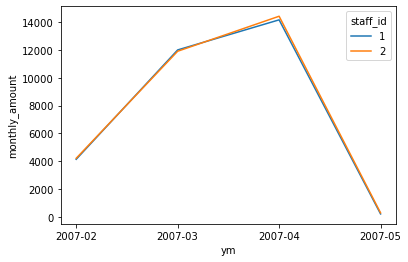

In [22]:
fig, ax = plt.subplots()
sns.lineplot(
    x = 'ym',
    y = 'monthly_amount',
    hue = "staff_id",
    ax = ax,
    data = df
)
plt.show()

## EX 6:
- Top 5 diễn viên có phim được bán chạy nhất trong năm 
- Mỗi diễn viên trong top 5 trên đóng bao nhiêu bộ 
- Plot diễn viên và số phim đã đóng

In [56]:
q = """
select  a.actor_id, 
        (first_name || ' ' || last_name) as full_name,
        SUM(amount) as sum_amount
from actor as a inner join film_actor as fa
        on a.actor_id = fa.actor_id
                inner join film as f
        on fa.film_id = f.film_id
                inner join inventory as i 
        on f.film_id = i.film_id
                inner join rental as r
        on i.inventory_id = r.inventory_id
                inner join payment as p
        on r.rental_id = p.rental_id
group by a.actor_id, (first_name || ' ' || last_name)
order by Sum_amount desc
limit 5
"""
df =  pd.read_sql(q,conn)
df

,actor_id,full_name,sum_amount
0,107,Gina Degeneres,3129.17
1,181,Matthew Carrey,2543.78
2,198,Mary Keitel,2426.92
3,81,Scarlett Damon,2403.81
4,102,Walter Torn,2403.18


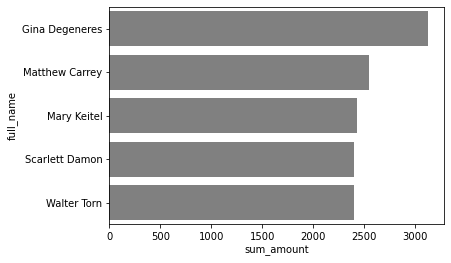

In [47]:
fig, ax = plt.subplots()
sns.barplot(
    x = 'sum_amount',
    y = 'full_name',
    orient='h',
    color = 'grey',
    ax = ax,
    data = df
)
ax.set_ylable = 'Full name'
ax.set_xlable = 'Sum amount'
plt.show()

In [48]:
top5_actor_ids = df['actor_id'].tolist()
top5_actor_ids

[107, 181, 198, 81, 102]

In [60]:
top5_str = ",".join([str(x) for x in top5_actor_ids])

q = """
select (first_name || ' ' || last_name) as full_name,
        count(*) as n_film
        
from actor a left join film_actor fa on a.actor_id = fa.actor_id
             left join film f on fa.film_id = f.film_id
where a.actor_id in ({})
group by a.actor_id, full_name

""".format(top5_str)
df2 = pd.read_sql(q, conn)
df2

,full_name,n_film
0,Mary Keitel,40
1,Scarlett Damon,36
2,Matthew Carrey,39
3,Walter Torn,41
4,Gina Degeneres,42


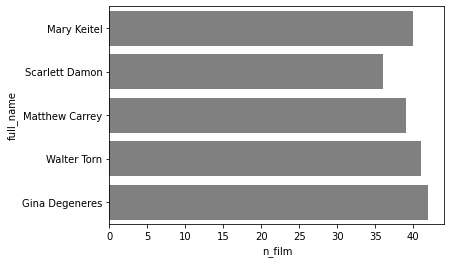

In [61]:
fig, ax = plt.subplots()
sns.barplot(
    x = 'n_film',
    y = 'full_name',
    orient='h',
    color = 'grey',
    ax = ax,
    data = df2
)
ax.set_ylable = 'Full name'
ax.set_xlable = 'n_film'
plt.show()

## Ex 7: 
- Khách hàng đến từ nước nào
- Doanh số theo từng nước (cao -> thấp) (có plot)

In [74]:
q = """
select
    distinct country,
    sum(amount) as total_amount
from payment p
left join customer c
on p.customer_id = c.customer_id
left join address a
on c.address_id = a.address_id
left join city c1
on a.city_id = c1.city_id 
left join country as c2 
on c1.country_id = c2.country_id
group by country
order by total_amount desc
limit 20
"""
df = pd.read_sql(q,conn)
df

,country,total_amount
0,India,6034.78
1,China,5251.03
2,United States,3685.31
3,Japan,3122.51
4,Mexico,2984.82
5,Brazil,2919.19
6,Russian Federation,2765.62
7,Philippines,2219.70
8,Turkey,1498.49
9,Indonesia,1352.69


In [78]:
plt.style.use("seaborn-whitegrid")

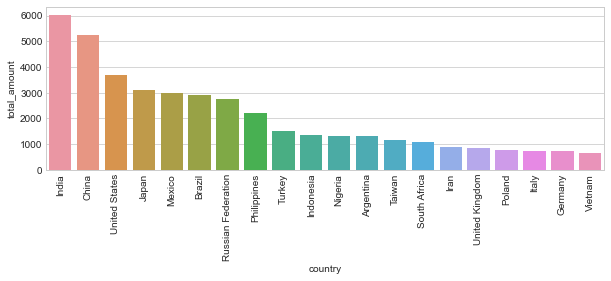

In [79]:
fig, ax = plt.subplots(figsize = (10,3))
sns.barplot(
    x = 'country',
    y = "total_amount",
    ax = ax,
    data =df, 
)
ax.set_xticklabels(df["country"].tolist(), rotation = 90)
plt.show()